In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd


In [3]:
df = pd.read_csv("../../data/AmesHousing.csv")


In [4]:
cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()


In [5]:
k = 10000

In [6]:
raw_y = df["SalePrice"].copy()
X = df.drop("SalePrice", axis=1).copy()

In [7]:
X = X.head(k)
raw_y = raw_y.loc[X.index].copy()

In [8]:
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

In [9]:
from utils import sort_categories, calculate_optimal_bins, mean_score

In [10]:
# Sort categories by the mean of the target
sorted_categories = sort_categories(X, raw_y, cat_cols, mean_score)
categories = [sorted_categories[col] for col in cat_cols]

In [11]:
y = (raw_y <= raw_y.quantile(0.25)).astype(int).copy()

In [80]:
from utils import *

In [13]:
X[cat_cols] = X[cat_cols].astype("category")

In [100]:
class SortedOrdinalEncoder:
    def __init__(self, sorter=None, encoded_missing_value=np.nan):
        self.sorter = sorter
        self.category_mappings = {}  # To store mappings created by the sorter
        self.encoded_missing_value = encoded_missing_value

    def fit(self, X, y):
        if self.sorter:
            self.sorter.fit(X, y)
            # Update the mappings based on the sorter directly
            for col in X.columns:
                if col in self.sorter.sorted_categories:
                    sorted_categories = self.sorter.sorted_categories[col]
                    # Create mapping, ensuring all categories are included and NaN is handled separately
                    category_mapping = {category: idx for idx, category in enumerate(sorted_categories) if category is not np.nan}
                    category_mapping[np.nan] = self.encoded_missing_value  # Explicit NaN mapping
                    self.category_mappings[col] = category_mapping
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for col in X_transformed.columns:
            if col in self.category_mappings:
                # Apply the mappings, and specifically handle NaNs according to encoded_missing_value
                X_transformed[col] = X_transformed[col].map(self.category_mappings[col])
                if self.encoded_missing_value is not np.nan:
                    X_transformed[col].fillna(self.encoded_missing_value, inplace=True)
        return X_transformed

    def inverse_transform(self, encoded_values):
        decoded_frames = {}
        for col in encoded_values.columns:
            if col in self.category_mappings:
                # We need to inverse map while considering the handling of missing values
                inverse_map = {v: k for k, v in self.category_mappings[col].items() if v != -1}
                inverse_map[self.encoded_missing_value] = np.nan  # Map encoded_missing_value back to NaN
                decoded_frames[col] = encoded_values[col].map(inverse_map)
        return pd.DataFrame(decoded_frames)

# Example usage might involve sorting categories and then encoding them:
sorter = CategoricalSorter(scoring_function=mean_scoring_func)  # Define your scoring function accordingly
encoder = SortedOrdinalEncoder(sorter=sorter)#, encoded_missing_value=-1)

# Example DataFrame
data = {'category': ['A', 'B', np.nan, 'A', 'C', 'B', 'A', np.nan, 'C', 'B']}
X = pd.DataFrame(data)
y = pd.Series([1, 0, 1, 0, 1, 0, 1, 0, 1, 0])  # Dummy target variable

encoder.fit(X, y)
encoded_X = encoder.transform(X)

print(encoded_X)

   category
0       1.0
1       0.0
2       NaN
3       1.0
4       2.0
5       0.0
6       1.0
7       NaN
8       2.0
9       0.0


In [103]:
# Strategy and Calculator Initialization
strategy = FreedmanDiaconisStrategy()
bin_calculator = NBinsCalculator(strategy=strategy)

# Discretizer Initialization with Bin Calculator
qcut_discretizer = PandasQCutDiscretizer(n_bins=bin_calculator)

# Sample Data
data = {
    'numeric1': np.random.normal(0, 1, 100),
    'numeric2': np.random.normal(5, 2, 100),
    'numeric3': np.random.randint(0, 50, 100)  # Integer data
}
X = pd.DataFrame(data)

# Applying the fit_transform method
discretized_data = qcut_discretizer.fit_transform(encoded_X)
print(discretized_data)

        category
0  (-0.001, 1.0]
1  (-0.001, 1.0]
2            NaN
3  (-0.001, 1.0]
4     (1.0, 2.0]
5  (-0.001, 1.0]
6  (-0.001, 1.0]
7            NaN
8     (1.0, 2.0]
9  (-0.001, 1.0]


In [92]:
%autoreload 2

In [34]:
%autoreload 2
sorter = CategoricalSorter(scoring_function=woe_score)
encoder = SortedOrdinalEncoder(sorter)
bin_calculator = NBinsCalculator(strategy=FreedmanDiaconisStrategy())
discretizer = PandasQCutDiscretizer(n_bins=bin_calculator)
rule_generator = RuleGenerator(discretizer)
evaluator = BinaryRuleEvaluator()
rule_filter = BinaryRuleFilter(min_recall=0.05, min_precision=0.1, min_WoE=0.01)

distinguisher = Distinguisher(encoder, discretizer, rule_generator, evaluator)
final_rules = distinguisher.find_rules(X, y, rule_filter)
# distinguisher.plot_rules_tree(chosen_rules)

In [31]:
final_rules

[Path: `Garage Type`.isna(),
 Path: `Garage Type`.isna() and `MS Zoning` in ['RM'],
 Path: `Garage Type`.isna() and `MS Zoning` in ['RM'] and `Lot Area` <= 10681.333,
 Path: `Garage Type`.isna() and `MS Zoning` not in ['RM'],
 Path: `Garage Type`.isna() and `MS Zoning` not in ['RM'] and `Neighborhood` in ['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor', 'Edwards', 'Gilbert', 'Greens', 'GrnHill', 'IDOTRR'],
 Path: `Garage Type`.isna() and `MS Zoning` not in ['RM'] and `Neighborhood` in ['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor', 'Edwards', 'Gilbert', 'Greens', 'GrnHill', 'IDOTRR'] and `Total Bsmt SF` <= 1168.0]

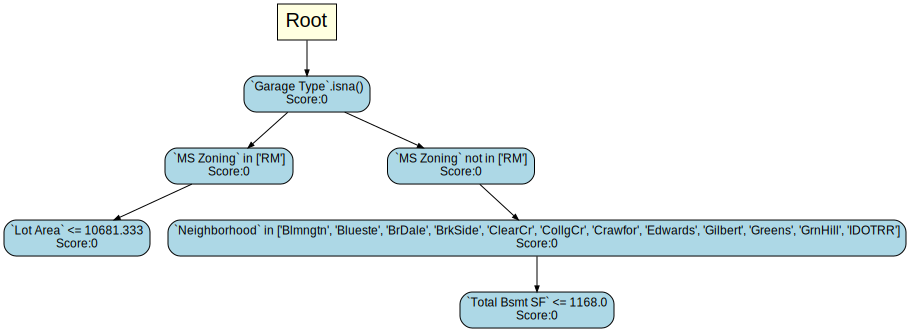

In [32]:
distinguisher.plot_tree(final_rules)

In [33]:
X.query("`Garage Type`.isna()")

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition
27,28,527425090,20,RL,70.0,10500,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,ConLI,Normal
119,120,534276360,20,RL,77.0,9320,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,Shed,400,1,2010,WD,Normal
125,126,534427010,90,RL,98.0,13260,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,Oth,Abnorml
129,130,534450180,20,RL,50.0,7207,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,2,2010,WD,Normal
130,131,534451150,30,RL,55.0,5350,Pave,NaN,IR1,Lvl,...,0,0,NaN,GdWo,Shed,450,5,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2913,2914,923226180,180,RM,21.0,1470,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Normal
2916,2917,923228130,180,RM,21.0,1533,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,8,2006,WD,Abnorml
2918,2919,923228210,160,RM,21.0,1526,Pave,NaN,Reg,Lvl,...,0,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal
2919,2920,923228260,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal


In [26]:
X.query("`Garage Type`.notnull()")

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2924,2925,923251180,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
2925,2926,923275080,80,RL,37.0,7937,Pave,NaN,IR1,Lvl,...,0,0,NaN,GdPrv,NaN,0,3,2006,WD,Normal
2926,2927,923276100,20,RL,NaN,8885,Pave,NaN,IR1,Low,...,0,0,NaN,MnPrv,NaN,0,6,2006,WD,Normal
2928,2929,924100070,20,RL,77.0,10010,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Normal
